# <center>DistilBERT model</center>

In [ ]:
# učitavanje standardnih biblioteka za numerička izračunavanja, analizu, manipulaciju i vizualizaciju podataka
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn

# ucitavaju se biblioteke za rad sa tekstom
import re
import string

# učitavanje neophodnih funkcija iz biblioteke scikit-learn
# biblioteka se instalira komandom : pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.utils import class_weight

# učitavanje neophodnih funkcija iz biblioteke TensorFlow
# biblioteka se instalira komandom : pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.metrics as metrics
import tensorflow_hub as hub

# učitavanje neophodnih funkcija iz biblioteke transformers
# biblioteka se instalira komandom : pip install transformers
import transformers
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel, DistilBertConfig

# učitavanje funkcije za podelu multi-labelarnih podataka iz biblioteke scikit-multilearn
# biblioteka se instalira komandom : pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification

# <center>Priprema podataka</center>

Koristeći *pandas* biblioteku, podaci zadati u formatu .csv (comma-separated values) učitavaju se u dataframe-ove. Oni su u startu podeljeni na trening i test podatke pa će na taj način i biti korišćeni.

In [ ]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

class_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'indentity_hate']

Definiše se funkcija koja ima za cilj da pripremi tekstualne podatke za prosleđivanje modelu. Odnosno njen zadatak je da očisti tekst od šumova. Neophodno je biti oprezan prilikom ovakvog preprocesiranja teksta. S obzirom da se koristi DistilBERT model koji može da nauči međusobne uticaje i odnose reči u rečenicama, ukljanjanjem određenih reči i simbola on neće biti u mogućnosti da ostvari svoj pun potencijal. Iz tog razloga se primenjuje blago čišćenje (korišćenjem regex-a) odnosno eliminišu se samo tokeni koji ne doprinose značenju teksta i predstavljaju šum.

In [ ]:
def clean_text(text):
    text =  text.lower()
    text = re.sub(r'\r', '', text)
    text = re.sub(r'(\(.*\))|(\[.*\])', '',text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'http[s]?\://\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub('\s{2,}', ' ', text)
    text = text.strip(' ')
    return text

Takođe je potrebno takozvane kontakcije napisati u punoj formi, ova funkcija je preuzeta i uz određene dopune/izmene dodata u rad. Originalna verzija biće navedena u literaturi.

In [ ]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not", "im" : "i am", "i'm" : "i am",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have","needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have","you're": "you are",
                     "you've": "you have","n't": "not","n'":"ng","till": "untill","'bout": "about","eg":"example"}

contractions_regex = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text, contractions_dict = contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_regex.sub(replace, text)

Definisane funkcije se potom primenjuju na komentare:

In [ ]:
train_data['comment_text'] = train_data['comment_text'].apply(clean_text)
test_data['comment_text'] = test_data['comment_text'].apply(clean_text)

train_data['comment_text'] = train_data['comment_text'].apply(expand_contractions)
test_data['comment_text'] = test_data['comment_text'].apply(expand_contractions)

Podaci se transformišu u adekvatan format za dalju upotrebu. 
Kako se u test skupu nalaze instance za koje nije definisana klasa kojoj pripadaju odnosno umesto 0 i 1 sve vrednosti su im -1, neophodno ih je izbaciti.

In [ ]:
x_train = train_data.comment_text.astype('string').to_numpy()
y_train = train_data.iloc[:, 2:].to_numpy()

# određuju se indeksi nekorektno zadatih instanci u test skupu
indeksi = np.where(test_labels.iloc[:, 1:].to_numpy().sum(axis = 1) != -6)[0]
# eliminišu se nekorektno zadate instance
x_test = test_data.comment_text.iloc[indeksi].astype('string').tolist()
y_test = test_labels.iloc[:, 1:].to_numpy()[indeksi]

Da bi se utvrdilo da li je moguće stratifikovati trening skup kako bi se izdvojio i validacioni skup za model koji će biti napravljen, neophodno je odrediti sve moguće kombinacije klasa kojima instance pripadaju. Standardne bibliotečke funkcije ne funkcionišu u multi-labelarnom slučaju pa je neophodno one-hot enkodiranje klasa pretvoriti u sparse kodiranje.

In [ ]:
# određuju se jedinstvene kombinacije klasa 
train_labels_unique = np.unique(y_train, axis = 0)
# kreira se niz indeksa za sparse kodiranje jedinstvenih klasa
train_labels_int = np.arange(0, len(train_labels_unique))
# u okviru liste čuvaju se dva načina kodiranja različitih klasa
z = [train_labels_unique, train_labels_int]
train_labels = []
# prolazi se kroz duplu petlju po indeksima instanci a onda po sparse oznaci različitih klasa
for i in range(0, len(y_train)):
  for j in range(0, len(train_labels_int)):
    # ispituje se da li je one-hot ekodiranje klase jednako datom
    if np.array_equal(y_train[i], z[0][j]):
      # ukoliko jeste dodeljuje mu se sparse enkodiranje
      train_labels.append(z[1][j])
# cuvaju se sparse kodiranja instanci
train_labels = np.array(train_labels)

Postoji 41 kombinacija klasa i broj instanci koje im pripadaju dat je u narednom delu

In [ ]:
pd.Series(train_labels).value_counts()

0     143346
12      5666
22      3800
20      1758
14      1215
36       989
23       618
6        317
2        301
37       265
8        181
34       158
13       136
15       134
25       131
16       113
39        64
26        56
1         54
27        41
21        35
40        31
3         28
4         22
9         18
18        16
29        14
24        11
31        11
17         7
30         7
35         6
38         4
5          3
19         3
28         3
7          3
10         2
11         2
33         1
32         1
dtype: int64

Kako postoje kombinacije klasa kojima pripada samo jedna instanca čak ni sparse kodiranje neće pomoći prilikom podele skupa na trening i validacioni deo standardnom *train_test_split* funkcijom. Stoga se ovaj problem rešava primenom funkcije *iterative_train_test_split* koja je prilagođena ovakvom problemu i definisana je oslanjajući se na *IterativeStratification* iz biblioteke *skmultilearn*.

In [ ]:
def iterative_train_test_split(X, y, test_size):
    # kreira se stratifikator koji polazni skup deli na dva dela u zadatoj razmeri obraćajući pažnju na multi-labelarnost
    # order 6 označava da je potrebno uzeti u obzir međuzavisnosti 6. reda odnosno za 6 dostupnih klasa
    stratifier = IterativeStratification(n_splits = 2, order = 6, sample_distribution_per_fold = [test_size, 1 - test_size, ])
    # definišu se indeksi trening i test skupa i vrši se podela podataka
    train_index, test_index = next(stratifier.split(X, y))
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    # vraća se podeljeni dataset
    return X_train, X_test, y_train, y_test

x_train, x_val, y_train, y_val = iterative_train_test_split(x_train, y_train, test_size = 0.25)

S obzirom da je u delu analize i pripreme podataka utvrđeno da je reč o nebalansiranom skupu podataka, potrebno je na neki način obraditi ovaj problem. Bazični oversampling i undersampling neće biti od koristi. Kako je svaki komentar autentičan i značajno se razlikuju među sobom oversamplingom se može stvoriti pristrasnost prema određenim rečima kao i jezičkim strukturama manjinskih klasa što nije poželjno. Sa druge strane smanjivanjem instanci dominantne klase će se značajno umanjiti skup podataka i time smanjiti sposobnost modela za uočavanje te klase. Tehnike kao što su SMOTE algoritam funkcionišu kada postoji prostor nad kojim se može definisati rastojanje što je moguće jedino učiniti kada se reči predstave na način razumljiv računaru, odnosno enkodiraju numerički. Tada će problem predstavljati to što će se veštačkim generisanjem novih instanci dobiti enkodirani tekst koji možda neće imati nikakvog smisla i negativno će uticati na proces učenja. Jedna od tehnika koja može biti korisna u ovom slučaju jeste zadavanje težina. S obzirom da se radi o multi-labelarnoj klasifikaciji potrebno je definisati novu funkciju za određivanje težina, jer bibliotečka nije od koristi. Naprednije tehnike za rešavanje ovog problema uključuju augmentaciju teksta baziranu na transformerima. Ovakve metode su izuzetno računski i vremenski zahtevne pa se po prioritetu primene nalaze na poslednjem mestu, samo u slučaju da su performanse modela izuzetno loše. 

Bitno je naglasiti da BERT modeli imaju strukturu neuronskih mreža, koje kao kompleksan model mogu da se dosta dobro prilagode i zadovoljavajuće obrade nebalansirane skupove podataka, stoga se neretko ne primenjuje nikakva vrsta procesiranja radi postizanja balansa klasa.

In [ ]:
def class_weights_multilabel(data, labels):
    # čuva se broj klasa 
    n_class = data.shape[1]
    # brojač instanci svake klase se inicijalizuje na nule
    class_counter = np.repeat(0, n_class)
    # za svaku instancu iz skupa podataka se prolazi kroz petlju
    for instance in data:
        # petljom prolazi se kroz skup mogućih klasa 
        for class_index in range(0, n_class):
            # vrši se provera da li instanca pripada određenoj klasi
            if instance[class_index] != 0:
                # ako da, brojač te klase se uvećava za 1
                class_counter[class_index] = class_counter[class_index] + 1

    # određuje se dimenzija skupa podataka
    n_data = data.shape[0]
    # formulom predloženom u standardnoj sample_weights funkciji računaju se težine klasa koristeći list comprehension            
    class_weights = [(n_data / (n_class * frequency)) if frequency > 0 else 1 for frequency in class_counter]
    # definišu se nazivi klasa
    class_labels = labels 
    
    # u vidu rečnika (klasa: težina) funkcija vraća težine klasa
    return dict(zip(class_labels, class_weights))

In [ ]:
sample_weights = class_weights_multilabel(y_train, class_labels)
sample_weights

{'toxic': 1.738848690901694,
 'severe_toxic': 16.67753623188406,
 'obscene': 3.147598758613434,
 'threat': 55.71601489757914,
 'insult': 3.3761566237869554,
 'indentity_hate': 18.92441492726123}

Kako prilikom testiranja više različitih težina nije dobijen rezultat kvalitetniji od obične primene modela, one neće biti korišćene prilikom treninga već deo vezan za nebalansiranost ima informacioni karakter.

Kako bi tekst komentara bio razumljiv računaru, neophodno je izvršiti embedding. Pre toga tekst se razdvaja na reči/tokene, na početku se dodaje token $[CLS]$ što označava klasifikator dok se na kraju svake rečenice dodaje token $[SEP]$ koji predstavlja separator teksta. Kako model obrađuje tekst u celosti a ne sekvencijalno, neophodno je definisati maksimalnu dužinu teksta koji će biti učitan. Na osnovu preliminarne analize utvrđuje se da je optimalna dužina $200$ reči (maksimalan podržan broj jeste $512$). Svaki tekst koji ima više od navedenog broja biće skraćen. U narednom koraku se specijalizovanim embedding slojem komentari se konvertuju u vektore od $200$ celobrojnih vrednosti, svaki token je predstavljen jednim elementom vektora, dok se eventualni preostali prostor dopunjuje nulama. Takođe se pored vektora embeddinga tokena, kreira i vektor maske koji predstavlja indikator da li je data pozicija vektora enkodirani token ($1$) ili predstavlja padding ($0$). Ovakav format je pogodan za prosleđivanje podataka modelu. Naredna slika prikazuje definisani postupak.



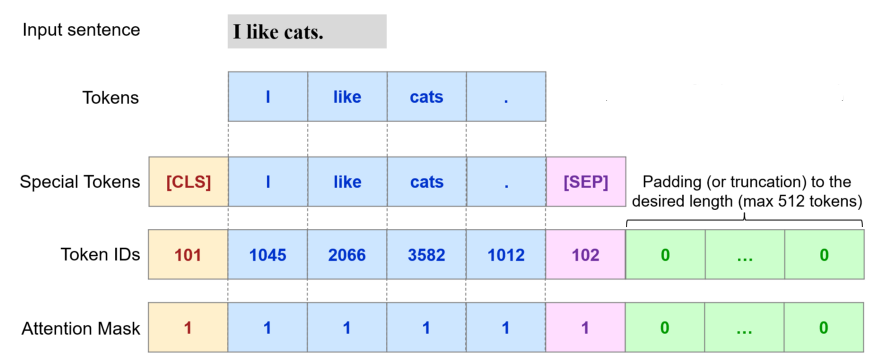

In [ ]:
# učitava se tokenizator DistilBERT modela
# sufiks Fast označava da je reč o implementaciji koja je vremenski efikasnija
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# definiše se funkcija koja vrši enkodiranje ulaza
def embedding(texts, tokenizer, max_len = 512):
    # definišu se liste u kojima će se smeštati embedding tokena kao i indikatori pozicije
    all_tokens = []
    all_masks = []
    
    # za svaki komentar iz skupa se prolazi kroz petlju
    for text in texts:
      # komentar se deli na tokene
        text = tokenizer.tokenize(text)

        # tekst se skraćuje na dozvoljenu dužinu - 2 (rezervisano za [CLS] i [SEP])    
        text = text[:(max_len - 2)]
        # na početak i kraj se dodaju redom tokeni klasifikacije [CLS] i separacije [SEP]
        input_sequence = ['[CLS]'] + text + ['[SEP]']
        # određuje se koliko je prostora ostalo nepopunjeno, u slučaju da tekst ima manje od max_len tokena
        length = max_len - len(input_sequence)
        
        # za svaki token se određuje numerička reprezentacija
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        # preostali prostor se popunjava nulama
        tokens = tokens + [0] * length
        # kreira se maska indikatora enkodiranog tokena
        masks = [1] * len(input_sequence) + [0] * length
        
        # dobijene vrednosti za tekući komentar se smeštaju u listu
        all_tokens.append(tokens)
        all_masks.append(masks)

    # fukcija kao povratnu vrednost prosleđuje ekodirane tokene i maske    
    return np.array(all_tokens, dtype = 'int32'), np.array(all_masks, dtype = 'int32')

Vrši se embedding teksta komentara iz trening, validacionog i test skupa:

In [ ]:
X_train = embedding(x_train, tokenizer, max_len = 200)
X_val = embedding(x_val, tokenizer, max_len = 200)
X_test = embedding(x_test, tokenizer, max_len = 200)

Token indices sequence length is longer than the specified maximum sequence length for this model (672 > 512). Running this sequence through the model will result in indexing errors


# <center>Konfiguracija modela</center>

Definiše se funkcija koja za cilj ima kreiranje DistilBERT modela za klasifikaciju komentara. Kao ulazi se modelu prosleđuju vektori embeddinga tokena tokena i vektori maski, koji se potom transformišu korišćenjem DistilBERT strukture sastavljene od $6$ enkodera (svaki ima $12$ glava sa mehanizmom pažnje). Prilikom obrade ulaza DistilBERT strukturom za svaki token se kao izlaz dobija vektor od $768$ vrednosti koji nose određenu informaciju. Kako je zadatak vršiti klasifikaciju komentara odnosno analizu sentimenta od interesa je izlaz poslednjeg sloja enkodera za (prvi) token $[CLS]$. Na taj izlaz se primenjuje gusti sloj koji ima cilj da odredi verovatnoću pripadanja tekućeg komentara svakoj od 6 mogućih klasa. S obzirom da je reč o multi-labelarnoj klasifikaciji kao aktivaciona funkcija se ne primenjuje $softmax$, što je uobičajeno kod problema klasifikacije. Razlog za to jeste što se tom prilikom komponente vektora koji daje verovatnoću pripadanja određenoj klasi sabiraju na 1. U tom slučaju se podrazumeva da svaka instanca pripada tačno jednoj klasi, što u datom problemu nije slučaj, te se gubi dosta informacije o instanci. Zato se primenjuje $sigmoid$ aktivacija, kako bi se procenila verovatnoća pripadanja instance svakoj klasi pojedinačno. Prilikom kompilacije modela za optimizacioni algoritam postavlja se Adam sa predloženim parametrima learning\_rate = 1e-5 i decay = 1e-6. Funkcija greške je binarna unakrsna entropija zbog toga što se koristi $sigmoid$ aktivacija pa će se greška računati pokoordinatno za svaki sigmoidni izlaz modela pojedinačno, iz tog razloga se koristi binarna umesto kategoričke unakrsne entropije. Što se tiče metrika za evaluaciju biće korišćene tačnost, preciznost i odziv (jer F1 skor nije podržan pa se u tom slučaju posmatraju vrednosti iz kojih je izveden) kao i AUC vrednost prilagođena za multi-labelarnu klasifikaciju.

In [ ]:
def build_model(transformer, max_len = 512):
    # kao ulazi se modelu prosleđuju ekodirani tokeni i vektori maske 
    input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'token_id_input')
    input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask_input')

    # prilikom klasifikacije komentara od značaja je samo izlaz kompozicije enkodera za (prvi - enumerisan sa 0) token odnosno [CLS]
    # stoga se izlaz ovog tokena u vidu vektora od 768 vrednosti čuva u promenljivoj cls_output
    cls_output = transformer([input_ids, input_mask])[0][:, 0, :]
    # gusti sloj sa 6 jedinica i sigmoidnom aktivacijom ima za cilj da za svaku klasu odredi verovatnoću pripadanja
    output = Dense(6, activation = 'sigmoid', name = 'classification_layer')(cls_output)
    
    # definišu se ulazi i izlazi modela
    model = Model(inputs = [input_ids, input_mask], outputs = output, name = 'DistilBert')

    # definišu se optimizacioni algoritam, greška kao i mere kvaliteta modela
    model.compile(optimizer = Adam(learning_rate = 1e-5, decay = 1e-6), loss = 'binary_crossentropy', metrics = [tf.metrics.BinaryAccuracy(name = 'accuracy'), tf.metrics.Precision(name = 'precision'), tf.keras.metrics.Recall(name = 'recall'), tf.metrics.AUC(multi_label = True, name = "AUC")])
    
    # funkcija vraća model
    return model

In [ ]:
# definiše se konfiguracija DistilBERT modela, pri čemu se zadržavaju predložene vrednosti, osim što se vrednost parametra Dropout 
# slojeva regularizacije postavlja na vrednost 0.2
config = DistilBertConfig(dropout = 0.2, attention_dropout = 0.2)
# definiše se pre-trenirani DistilBERT model sa zadatom konfiguracijom
distilbert_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)
# kreira se model sa zadatim parametrima i ispisuje se izveštaj
model = build_model(distilbert_layer, max_len = 200)
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "DistilBert"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_id_input (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 attention_mask_input (InputLay  [(None, 200)]       0           []                               
 er)                                                                                              
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['token_id_input[0][0]',         
 BertModel)                     ast_hidden_state=(N               'attention_mask_input[0][0]']   
                                one, 200, 768),                                          

# <center>Trening modela</center>

Vrši se treniranje modela u 3 epohe sa sa veličinom paketa 32, za validaciju se koriste prethodno definisani skupovi.

In [ ]:
train_history = model.fit(X_train, y_train, epochs = 3, batch_size = 32, validation_data = (X_val, y_val))

Epoch 1/3
3740/3740 [==============================] - 2581s 687ms/step - loss: 0.0489 - accuracy: 0.9817 - precision: 0.7973 - recall: 0.6714 - AUC: 0.9703 - val_loss: 0.0402 - val_accuracy: 0.9841 - val_precision: 0.7885 - val_recall: 0.7746 - val_AUC: 0.9825
Epoch 2/3
3740/3740 [==============================] - 2571s 687ms/step - loss: 0.0372 - accuracy: 0.9851 - precision: 0.8282 - recall: 0.7477 - AUC: 0.9855 - val_loss: 0.0458 - val_accuracy: 0.9813 - val_precision: 0.6951 - val_recall: 0.8712 - val_AUC: 0.9846
Epoch 3/3
3740/3740 [==============================] - 2572s 688ms/step - loss: 0.0331 - accuracy: 0.9864 - precision: 0.8390 - recall: 0.7798 - AUC: 0.9894 - val_loss: 0.0399 - val_accuracy: 0.9840 - val_precision: 0.7580 - val_recall: 0.8280 - val_AUC: 0.9825


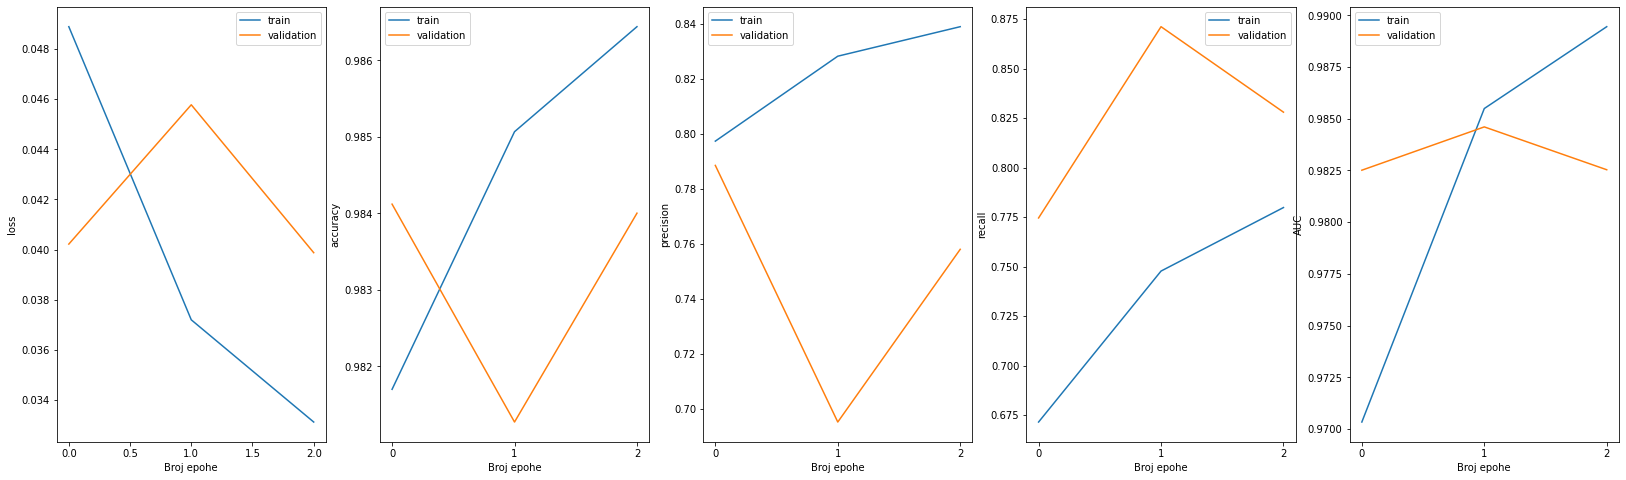

In [ ]:
# čuva se broj u koliko je epoha treniran model
epochs = train_history.epoch

# čuvaju se vrednosti greške kao i mera kvaliteta na trening i validacionom skupu
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

accuracy = train_history.history['accuracy']
val_accuracy = train_history.history['val_accuracy']

precision = train_history.history['precision']
val_precision = train_history.history['val_precision']

recall = train_history.history['recall']
val_recall = train_history.history['val_recall']

AUC = train_history.history['AUC']
val_AUC = train_history.history['val_AUC']


# iscrtava se grafik zadate veličine
plt.figure(figsize = (28, 8))

# za svaki od korišćenih kriterijuma iscrtava se grafik vrednosti greške/mere kvaliteta u zavisnosti od broja epohe
plt.subplot(1, 5, 1)
plt.plot(epochs, loss, label = 'train')
plt.plot(epochs, val_loss, label = "validation")
plt.xlabel('Broj epohe')
plt.ylabel('loss')
plt.legend(loc = 'best')

plt.subplot(1, 5, 2)
plt.plot(epochs, accuracy, label = 'train')
plt.plot(epochs, val_accuracy, label = 'validation')
plt.xticks(epochs)
plt.xlabel('Broj epohe')
plt.ylabel('accuracy')
plt.legend(loc = 'best')

plt.subplot(1, 5, 3)
plt.plot(epochs, precision, label = 'train')
plt.plot(epochs, val_precision, label = 'validation')
plt.xticks(epochs)
plt.xlabel('Broj epohe')
plt.ylabel('precision')
plt.legend(loc = 'best')

plt.subplot(1, 5, 4)
plt.plot(epochs, recall, label = 'train')
plt.plot(epochs, val_recall, label = 'validation')
plt.xticks(epochs)
plt.xlabel('Broj epohe')
plt.ylabel('recall')
plt.legend(loc = 'best')

plt.subplot(1, 5, 5)
plt.plot(epochs, AUC, label = 'train')
plt.plot(epochs, val_AUC, label = 'validation')
plt.xticks(epochs)
plt.xlabel('Broj epohe')
plt.ylabel('AUC')
plt.legend(loc = 'best')

# prikazuje se grafik
plt.show()

# <center>Evaluacija modela i analiza rezultata</center>

Model se evaluira na test skupu pri čemu se ispisuju dobijene mere kvaliteta.


In [ ]:
eval = model.evaluate(X_test, y_test)
print('\nEvaluacija modela na test skupu:\nLoss : {}\nAccuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {} '.format(np.round(eval[0], 3), np.round(eval[1], 3), np.round(eval[2], 3), np.round(eval[3], 3), np.round(eval[4], 3)))

2000/2000 [==============================] - 433s 216ms/step - loss: 0.0800 - accuracy: 0.9659 - precision: 0.5307 - recall: 0.8478 - AUC: 0.9789

Evaluacija modela na test skupu:
Loss : 0.08
Accuracy : 0.966
Precision : 0.531
Recall : 0.848
AUC : 0.979 


Predviđaju se vrednosti klasa na test skupu kako bi moglo da se pristupi daljoj analizi kroz matrice konfuzije i klasifikacioni zveštaj

In [ ]:
y_pred = model.predict(X_test)

Za svaku od klasa se kreira matrica konfuzije koje se potom radi preglednosti prikazuju toplotnim mapama

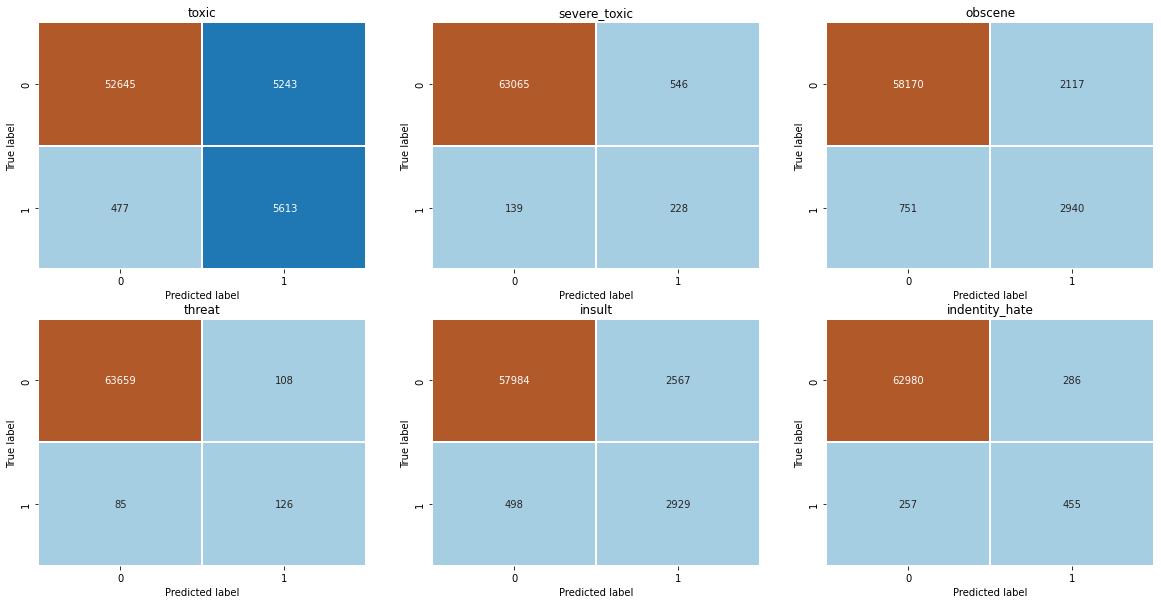

In [ ]:
confusion_matrices = multilabel_confusion_matrix(y_test, np.round(y_pred))

# iscrtava se grafik zadate veličine
plt.figure(figsize = (20, 10))
# brojač se inicijalizuje na nulu
i = 0
# petljom se prolazi kroz matrice konfuzije za svaku klasu
for single_matrix in confusion_matrices:
  # kreira se plot za svaku matricu konfuzije pojedinačno tako da su poređani u 2 reda i 3 kolone
  ax = plt.subplot(2, 3, i + 1)
            
  # toplotnom mapom se iscrtavaju matrice konfuzije
  seaborn.heatmap(single_matrix, annot = True , fmt = 'd', linewidths = 1, cmap = 'Paired', cbar = False)
  # ispisuju se imena naslova, x i y ose
  ax.set_title(class_labels[i])
  ax.set_xlabel('Predicted label')
  ax.set_ylabel('True label')
  # uvećava se brojač
  i = i + 1

Na osnovu vrednosti iz matrica konfuzije, za svaku od klasa, moguće je izračunati standardne mere kvaliteta koje kvantifikuju prediktivne performanse modela.

In [ ]:
print(classification_report(y_test, np.round(y_pred), zero_division = 0, target_names = class_labels))

                precision    recall  f1-score   support

         toxic       0.52      0.92      0.66      6090
  severe_toxic       0.29      0.62      0.40       367
       obscene       0.58      0.80      0.67      3691
        threat       0.54      0.60      0.57       211
        insult       0.53      0.85      0.66      3427
indentity_hate       0.61      0.64      0.63       712

     micro avg       0.53      0.85      0.65     14498
     macro avg       0.51      0.74      0.60     14498
  weighted avg       0.54      0.85      0.65     14498
   samples avg       0.08      0.08      0.08     14498



Analizom dobijenih rezultata uviđa se da je greška modela mala ($0.08$), takođe tačnost predviđanja i mera AUC su izuzetno visoke ($0.966$ i $0.979$ redom) što govori da je veliki broj instanci korektno klasifikovan. Iako model deluje zadovoljavajuće potrebno je detaljnije analizirati način na koji model svrstava komentare u klase. Odziv od $0.848$ govori o tome koliki je udeo komentara koje je model korektno klasifikovao kao neprikladne među svim stvarno neprikladnim komentarima. Sa druge strane preciznost od $0.531$ govori o udelu komentara koje je model korektno klasifikovao kao neprikladne među svim onima koji su kao takvi označeni od strane modela. Iz prethodnog direktno sledi da model često pogrešno klasifikuje komentare korektnog sadržaja kao neprikladne odnosno postoji veći broj lažno pozitivnih instanci. U ovom slučaju model zadovoljavajuće prepoznaje komentare neprikladnog sadržaja ali zajedno sa njima u istu kategoriju svrstava i određen broj komentara korektnog sadržaja. Svakako ovakvo ponašanje modela je bolje nego slučaj u kome bi preciznost bila veća nego odziv. Tada bi postojala veća verovatnoća da model ne prepozna komentare sa neprikladnim sadržajem i oni, prilikom primene modela u praksi, ne bi bili eliminisani sa platforme *Wikipedia*. 

Nebalansiranost može predstavljati problem, ali kako su modeli zasnovani na BERT-u složene strukture oni mogu da se izuzetno dobro prilagode. Tako će model biti istreniran da se neprikladni komentari pojavljuju sa manjom frekvencijom, što će uticati pozitivno na njegove performanse prilikom primene na realnim podacima. Nasuprot tome, u veštački balansiranom skupu bi se tokšični komentari pojavljivali češće, što u praksi ne bi bio slučaj, te bi model bio pristrasan i greška bi se akumulirala.

Model se čuva kako bi mogao da bude naknadno korišćen.

In [ ]:
model.save('models/distilbert_model.h5')